# Gene Prediction Pipeline

## Introduction

This project was based on the 2008 paper ['Gene prediction in metagenomic fragments: A large scale machine learning approach'](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-217) by Hoff et at. The goal of this notebook is to train the gene prediction algorithm using a 2-stage approach - linear discriminant and neural network. The linear discriminant model reduces high dimensional features and the neural network predicts if a given sequence is a gene or not. My intentions for starting this project were to gain a deeper understanding of machine learning approaches behind the `Orphelia gene prediction algorithm` and sharpen my programming skills. 

Useful notebooks/files:
* `Sampling True NCS Dataset.ipynb` to see how NCS are sampled,
* `./modules` folder to see documentation on all methods,
* `./examples` folder for example code.

## Google Colab Setup

First clone the `gene-prediction` repository to Google Colab (see setup in `README.md`). Then install dependencies (see code below).

In [ ]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/My Drive/

# # Clone github repo
# !git clone https://github.com/viggy-ravi/gene-prediction.git

# # Change to project directory
# %cd gdrive/My Drive/gene-prediction

# # Install dependencies
# !pip install -r requirements.txt

# # Install biopython library manually
# !pip3 install biopython

# # Pull latest code
# !git pull

# Training Binary Classification Model

In [1]:
# will inform your notebook to actively reload all imported modules and packages as they are modified
%reload_ext autoreload
%autoreload 2
from modules.preprocess import preprocess_genome, split_training_records, plot_data_distributions
from modules.extract import extract_ld_training_features, extract_nn_training_features
from modules.train import discriminant, tis_gaussian
from modules.predict import dimensional_reduction
from modules.utils import plot_confusion_matrix, load_params, save_model2json, save_params2csv

import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn import metrics
# suppress tf messages/warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Preprocess Genome

Preprocessing a genome consists of finding all valid open reading frames (ORFs). ORFs start with a start codon (ATG, CTG, GTG, or TGT) and end with an in-frame stop codon (TAG, TGA, or TAA). To train our neural network, we need to find positive ORFs - sequencies that code for a protein (i.e. genes) -  and negative ORFs - sequencies in the genome that start with a start codon and end with an in-frame stop codon, but don't code for a protein. The negative ORFs can be found in the intergenic regions (interregions) of a genome or spaces between genes. For this project, positive ORFs will be referred to as CDS or **C**o**D**ing **S**equences, and negative ORFs will be referred to as NCS or **N**on **C**oding **S**equences.

Input arguments for `preprocess.genome`
* **filename** - `txt` file containing list of accession numbers (gb genomes) (see `./input` folder for examples)
* **n_genomes** - number of genomes from input file to use for training (`=None` to train on all genomes in file)
* **seq** - `all` (default), `cds`, or `ncs` to extract either all orfs from genome, only cds, or only ncs respectively
* **e** - parameter [0,1] to limit length of NCS (default `=0.005`). Larger value allows fewer NCS
* **tol** - parameter [0,1] for stochastic sampling of NCS (default `=0.2` - lets in 80% NCS data). Larger value allows fewer NCS
* **OFFSET** - number of basepairs before and after sequence (default is `30` for tis feature)
* **LMIN** - minimin length of ORFs (CDS or NCS) used for training (default is `60` bp ORFs - ref: Hoff et al.)
* **random_state** - random seed (default `=None`)

In [2]:
infile = './input/train.txt'
SEED   = 8    # set to number (for reproducibility) or None

%time CDS, NCS = preprocess_genome(filename = infile, \
                                   n_genomes = 1, \
                                   e = 0.05, \
                                   tol = 0.9, \
                                   random_state=SEED, \
                                   email = 'vignesh.ravindranath@gmail.com')

Successfully fetched NC_000917
	2478 CDS Records

	5114 NCS Records

2478 Total CDS Records
5114 Total NCS Records
CPU times: user 1min 5s, sys: 516 ms, total: 1min 6s
Wall time: 1min 25s


In [3]:
import sys
print(f'{sys.getsizeof(CDS) / 1000} kB')
print(f'{sys.getsizeof(NCS) / 1000} kB')

22.4 kB
46.128 kB


### Plot Distribution of Data

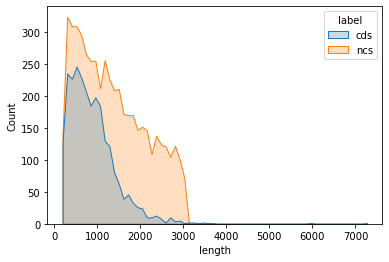

In [4]:
plot_data_distributions(CDS, NCS, x='length')

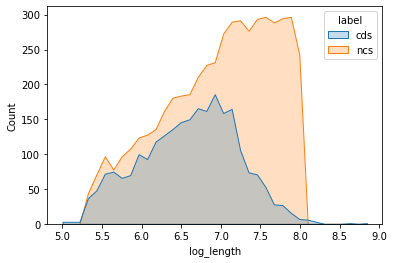

In [5]:
plot_data_distributions(CDS, NCS, x='log_length')

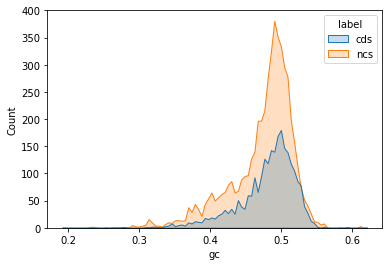

In [6]:
plot_data_distributions(CDS, NCS, x='gc')

### SeqRecord Structure

The CDS and NCS data are lists of Biopython **SeqRecord** that contain information about each sequence, such as `ID`, `Name`, `Description`, `Number of features`, and `Seq`.

* `ID` is the GenBank accession number for the prokaryotic genome the sequence was extracted from. 
* `Name` is a auto-generated identifier that the program creates for each sequence. 
* `Description` is blank. 
* `Number of features` includes another Biopython data structure called **SeqFeature** that contains information about the type (CDS or NCS), start location on the genome, the stop location on the genome, and what strand the gene originated from - (+) if it came from the template strand and (-) if it came from the coding strand. 
* `Seq` is another Biopython object that contains the sequence of the gene. 

**NOTE**: the sequence contains a buffer of *30 basepairs upstream of the start codon* and *30 basepairs downstream of the stop codon*. The additional information is necessary to extract the TIS feature.

In [7]:
# example of cds SeqRecord
example_record = CDS[0]

print(example_record.id)
print(example_record.name)
print(example_record.description)
print(example_record.features[0])
print(example_record.seq[30:-30])

NC_000917
AF_RS00005
<unknown description>
type: CDS
location: [4289:4784](+)
qualifiers:

ATGAAAGAGACGATTCAGCTTGCTATAGGGGTGATGCTGTTGGCCATGCTCGGTTGCTACATCTACATTACTGAGTTCTATCACTACGAATCAACTGAAGAGAGCTCAAAAGCTGCGATTGAATATTTGAATCAGCTTAGAGCTCAGAATGGCCTGCCTCCTGTAAAGTGGAATAAAACTCTTTACGAGTTTGCGCTGGAAAGGCTTGAAGATATGCATGAAAGAGGCTATTACAGTCATTATGACCCTGTTACGCATGAGACGCTGATTTACAGATATGTTGAGGGGTATGTTGGAGAGTGTATCTTGAATGGTGTAAGAGGTACAAATCTTCTCTCCAATGGGCTTCAGTCATTATTTGGCTATGAAGAAGAAGCTATAGATATCTGGTCTAAAAGCACCATGCACAAACTCATTCTCACTGATAAACGCTTCACAGATGCCGCTGTAGCCTGCAAGTACGACATGTGTGTTTTGATTATGACGGGTGGTTGA


### Shuffle and Split Training Data

Training data is split into two datasets - one to train the linear discriminant weight vectors and one to train the neural network.

In [8]:
# merge CDS and NCS data
DATA = CDS + NCS

# shuffle and split data
LD_Data, NN_Data = split_training_records(DATA, size=0.5, random_state=SEED, shuffle=True)

In [9]:
print(f'LD Dataset: {len(LD_Data)}')
print(f'NN Dataset: {len(NN_Data)}')

LD Dataset: 3796
NN Dataset: 3796


In [12]:
# # save records as FASTA file
# from modules.predict import seqrecord2fasta
# seqrecord2fasta(filename = './input/train_1g.fna', seq_records=DATA)

Saved genome fragments to ./input/train_1g.fna.


## Train Linear Discriminant Weight Vectors for Dimensional Reduction

### Extract Features - Monocodon (Tri), Dicodon (Hex), TIS

Common meaningful features that are extracted from a genome include the `codon frequency` (monocodon or tri), the `dicodon frequency` (dicodon or hex), the `translation initiation sites` (TIS), and `GC content`. For training the linear discriminant, only the first three features will be extracted since they are highly dimensional. 
* Codon Frequency - ex. ATGCCC... => 'ATG', 'CCC', ...
* Dicodon Frequency - ex. ATGCCCTTT... => 'ATGCCC', 'CCCTTT', ...
* TIS - frame that includes 30 basepairs (bp) upstream and downstream of start codons

**Note:** TIS features are different for discriminant training vs NN training. For discriminant training, TIS features are from CDS only - a TIS frame starting at the true start codon is positive; a TIS frame starting at a start codon within the gene is negative. See the `Hoff et al.` paper for more information on features.

Input arguments for `extract.training_features`
* **seq_records** - list of linear discriminant SeqRecords
* **OFFSET** - default `=30`

Return types for `extract.training_features`
* **X_M** - monocodon features 
* **X_D** - dicodon features
* **y_cod** - labels for codon features
* **X_T** - training tis features
* **y_tis** - labels for training tis features

In [13]:
%time X_M, X_D, y_cod, X_T, y_tis = extract_ld_training_features(LD_Data, OFFSET=30)

CPU times: user 11.2 s, sys: 1.03 s, total: 12.2 s
Wall time: 12.2 s


### Train Discriminant Weight Vectors

We need to minimize:

$$ E(w_M) = \frac{1}{n}\sum_{i=0}^{n}(w_m \cdot x_M^i - y_i)^2 + \lambda w_M \cdot w_M $$

where $x_M^i \in \mathbb{R}^{64}$ is the $i-th$ column of the monocodon frequency matrix $\textbf{X}_M$, $n=64$ monocodon possibilities, $y_M^i \in (-1, 1)$ is the $i-th$ element of the label vector, and $w_M$ is the discriminant weight vector.

We can minimize $E$ by:

$$w_M = (X_MX_M^T +\lambda n\textbf{I})^{-1}X_My_M$$

This can be generalized to train the discriminant vector $w$ for dicodon frequency and TIS. 

In [14]:
wM = discriminant(X_M, y_cod)
wD = discriminant(X_D, y_cod)
wT = discriminant(X_T, y_tis)
w = [wM, wD, wT]

In [15]:
print(f'Weights Shape: wM {w[0].shape}, wD {w[1].shape}, wT {w[2].shape}')

Weights Shape: wM (64,), wD (4096,), wT (3712,)


### Train TIS Gaussian Parameters 

Ideally, input sequences into the prediction algorithm will contain all the information we need to determine if the sequence is a gene or not. However, next-generation sequencing (NGS) tools often produce fragments of DNA that vary in length from 100 bp to 700 bp. Therefore, the entire TIS region (30 bp upstream of the start codon to 30 bp downstream of the start codon) may not be present in the input sequence. 

To overcome this, a Gaussian distribution can be trained on the training genomes provided. Then, we can predict how likely a given fragment of a TIS window is from a gene or not.

In [16]:
%time p = tis_gaussian(X_T, y_tis, wT)

CPU times: user 734 ms, sys: 859 ms, total: 1.59 s
Wall time: 1.24 s


In [17]:
print(f'Pos (pi, mu, sd): {round(p[0][0],4)}, {round(p[1][0],4)}, {round(p[2][0],4)}')
print(f'Neg (pi, mu, sd): {round(p[0][1],4)}, {round(p[1][1],4)}, {round(p[2][1],4)}')

Pos (pi, mu, sd): 0.0436, 0.5817, 0.2656
Neg (pi, mu, sd): 0.9564, 0.0191, 0.0861


### Visualize TIS Weight Vector

<AxesSubplot:>

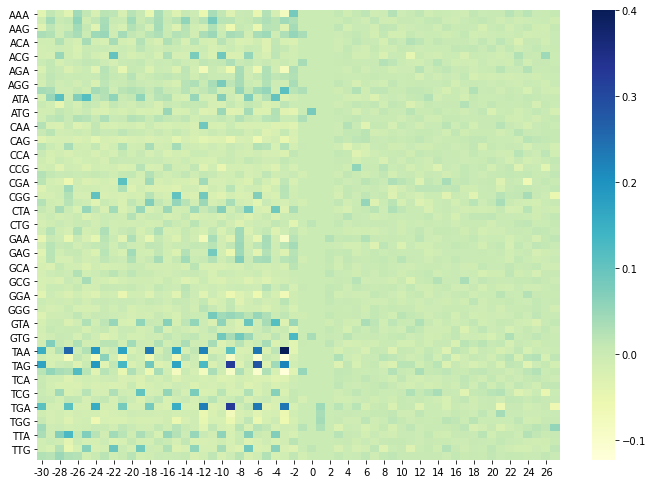

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modules.extract import populate_codon_idx_dict

tis_weights = np.array(w[2]).reshape(58,64).T

y_axis_labels = populate_codon_idx_dict(nbases=3).keys()
x_axis_labels = [i for i in range(-30,28)]

df = pd.DataFrame(tis_weights, columns=x_axis_labels, index=y_axis_labels)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df, cmap="YlGnBu")

## Train Binary Classification Neural Network

In [9]:
# # load latest parameters
# data = load_params("./model/param_1g.csv")
# w, p = data[0:3], data[3:]

Loaded parameters from disk.


### Extract Features

Return types for `extract.features`
* **features** - all features (monocodon, dicodon, tis, length, gc)
* **y** - labels for features

In [19]:
%time NN_features, NN_y = extract_nn_training_features(NN_Data)

CPU times: user 8.64 s, sys: 0 ns, total: 8.64 s
Wall time: 8.64 s


In [20]:
print(f'({len(NN_features[0])},{len(NN_features)})')
print(f'({len(NN_y)},)')

(3796,5)
(3796,)


### Dimensionally Reduce Large Features

Return types for `predict.dimensional_reduction`
* **nn_input** - (n,5) matrix of reduced features

Features include:
* x1 = reduced monocodon frequency
* x2 = reduced dicodon frequency
* x3 = positive tis score (gaussian probability)
* x4 = negative tis score (gaussian probability)
* x5 = length
* x7 = gc content

In [21]:
%time nn_input = dimensional_reduction(NN_features, w, p)

CPU times: user 1.89 s, sys: 609 ms, total: 2.5 s
Wall time: 904 ms


In [22]:
print(f'({len(nn_input)}, {len(nn_input[0])})')

(3796, 6)


### Test, Train, Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(nn_input, NN_y, test_size=0.2, random_state=SEED)

In [24]:
print(len(X_train), len(X_train[0]), len(y_train))
print(len(X_test), len(X_test[0]), len(y_test))

3036 6 3036
760 6 760


### Define Neural Network Model

In [25]:
model = Sequential()
model.add(Dense(25, input_dim=len(nn_input[0]), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                175       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


### Train Neural Network

In [27]:
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
48/48 [==============================] - 0s 1ms/step - loss: 26.6532 - accuracy: 0.6446
Epoch 2/50
48/48 [==============================] - 0s 1ms/step - loss: 1.1264 - accuracy: 0.6831
Epoch 3/50
48/48 [==============================] - 0s 1ms/step - loss: 0.4620 - accuracy: 0.8258
Epoch 4/50
48/48 [==============================] - 0s 1ms/step - loss: 0.4292 - accuracy: 0.8613
Epoch 5/50
48/48 [==============================] - 0s 1ms/step - loss: 0.3952 - accuracy: 0.8976: 0s - loss: 0.3984 - accuracy: 0.89
Epoch 6/50
48/48 [==============================] - 0s 1ms/step - loss: 0.3809 - accuracy: 0.8910
Epoch 7/50
48/48 [==============================] - 0s 1ms/step - loss: 0.3460 - accuracy: 0.9233
Epoch 8/50
48/48 [==============================] - 0s 1ms/step - loss: 0.3515 - accuracy: 0.9068
Epoch 9/50
48/48 [==============================] - 0s 1ms/step - loss: 0.3134 - accuracy: 0.9236
Epoch 10/50
48/48 [==============================] - 0s 1ms/step - loss: 0.2921 -

### Evaluate Model

In [28]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 93.29%


Confusion matrix, without normalization
[[510   7]
 [ 44 199]]


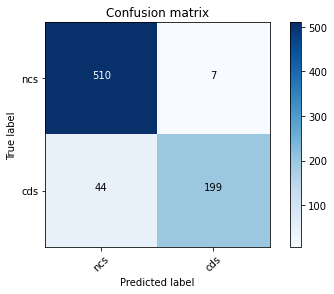

In [29]:
# make predictions + convert predictions to 1 or 0 (cutoff = 0.5)
predictions = model.predict(X_test)
y_pred = [1 if val >= 0.5 else 0 for val in predictions]

# plot confusion matrix
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cm=cm, classes=['ncs','cds'], normalize=False)

## Save

In [30]:
# save NN model as JSON/H5
save_model2json("./model/model_1g", model)

Saved model to disk.


In [31]:
# save weights and TIS Gaussian parameters
data = w + p
save_params2csv("./model/param_1g.csv", data)

Saved data to disk.


# Gene Prediction

In [32]:
%reload_ext autoreload
%autoreload 2
from modules import predict

## How to use Gene Prediction Tools

### Option 1: Extract Sequences from GenBank Genome

The `predict.from_genome` method extracts sequences from input genomes (txt file of accession numbers), creates a temporary FASTA file in the `./input` folder called `tmp.fna` that contains all extracted sequences in the FASTA format, and creates an output prediction file with the sequences that it predicted as genes.

In [33]:
gb_file = './input/train.txt'      # txt file of genbank accession numbers
num = 1                            # number of genomes to extract from input txt file
seq = 'cds'                        # only getting CDS sequences 

par = './model/param_1g.csv'       # saved csv of parameter values (w, p)
mod = './model/model_1g'           # saved json/h5 of NN model
out = './results/gb_pred_test.fna' # location of prediction results

In [34]:
%time pg = predict.from_genome(filename=gb_file, \
                               n_genomes=num, \
                               params=par, \
                               model=mod, \
                               outfile=out, \
                               seq=seq, \
                               email='vignesh.ravindranath@gmail.com')

Successfully fetched NC_000917
	2478 CDS Records

2478 Total CDS Records
0 Total NCS Records
Loaded parameters from disk.
Loaded model from disk.
Saved genome fragments to ./results/gb_pred_test.fna.
CPU times: user 24.5 s, sys: 828 ms, total: 25.3 s
Wall time: 44.1 s


Confusion matrix, without normalization
[[   0    0]
 [ 393 2085]]


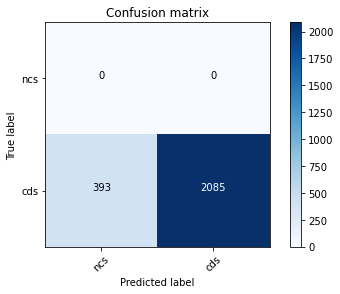

In [36]:
# create confusion matrix
y_true_op2 = [1]*len(pg)
cm_op2 = metrics.confusion_matrix(y_true=y_true_op2, y_pred=pg)

# plot confusion matrix
plot_confusion_matrix(cm=cm_op2, classes=['ncs','cds'], normalize=False)

### Option 2 (NEED TO FIX): Input FASTA File Containing Sequences

Using `tmp.fna` file created from the `predict.from_genome` method above as the example input.

In [ ]:
# fna_file = './input/tmp.fna'          # input fasta file

# par = './model/param_1g.csv'          # saved csv of parameter values (w, p)
# mod = './model/model_1g'              # saved json/h5 of NN model
# out = './results/fasta_pred_test.fna' # location of prediction results

In [ ]:
# % time pf = predict.from_fasta(filename=fna_file, \
#                                params=par, \
#                                model=mod, \
#                                outfile=out)

In [ ]:
# # create confusion matrix
# y_true_op3 = [1]*len(pf)
# cm_op3 = metrics.confusion_matrix(y_true=y_true_op2, y_pred=pg)

# # plot confusion matrix
# genepred.plot_confusion_matrix(cm=cm_op3, classes=['ncs','cds'], normalize=False)

## Input your sequences for prediction